## Analysis of accessible food services to low income households

This project is for IBM Data Science Capstone.

### Problem Description

In times of the 2020 global pandemic COVID-19, low income households in Singapore may find daily life difficult to manage due to the circuit breaker implementations. These households struggle with living expenses and insufficient financial support. Some neighborhoods might not be  as accessible to food services as others.


The objective of this analysis is to identify clusters of low income households which have few available food services in their vicinity, so that these neighborhood can be prioritised for food charity handouts to maximise the effectiveness of a community support initiative.

### Data Description

The data set used in this analysis is from the Singapore Ministry of Trade and Industry - Department of Statistics, available at: https://data.gov.sg/dataset/resident-working-persons-aged-15-years-over-by-planning-area-gross-monthly-income-from-work-2015. 
The data set consist of the 2015 income data of Singapore residents in each planning area. Planning Areas, also known as DGP areas or DGP zones, are the main urban planning and census divisions of Singapore delineated by the Urban Redevelopment Authority. They will be interpreted as 'Neighborhood' for boundary division in this analysis.


*(Disclaimer: 2020 data set is not available at the point of this writing; this General Household Survey is a series of mid-decade national survey, so data are only available in 5 year intervals [2000, 2005, 2010, 2015].)*

### Approach

- Identify population number in each income bracket for each planning area
- Using Fourspace API, search for recommended budget food services in a 2.5km radius vicinity
- Group population and cluster planning area, according to income bracket and number of available food services available in vicinity
- Identify similar planning areas which are on top priority for food charity handouts (criteria: low income + lack of food services nearby)

__1. Initialise Dataset__


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_income = pd.read_csv('Planning Area Income.csv')
df_income.drop(columns=['year','level_2'],inplace=True)
df_income.columns = ['Income Bracket','Planning Area','Count (Thousands)']
df_income

,Income Bracket,Planning Area,Count (Thousands)
0,Total,Ang Mo Kio,101.2
1,Total,Bedok,150.3
2,Total,Bishan,49.5
3,Total,Bukit Batok,75.6
4,Total,Bukit Merah,82.2
5,Total,Bukit Panjang,80.1
6,Total,Bukit Timah,36.8
7,Total,Choa Chu Kang,97.2
8,Total,Clementi,45.9
9,Total,Geylang,61.4


In [3]:
# Create income data frame
index = df_income.groupby('Income Bracket').size().keys()
columns = df_income.groupby('Planning Area').size().keys().values
df = pd.DataFrame(index=index,columns=columns)

# Insert data
for name, group in df_income.groupby('Planning Area'):
    df.loc[:,name] = group.sort_values('Income Bracket',ascending=True)['Count (Thousands)'].values 

df.drop(columns=['Others'],inplace=True)
df = df.T
df.head()

Income Bracket,"$1,000 - $1,499","$1,500 - $1,999","$10,000 - $10,999","$11,000 - $11,999","$12,000 & Over","$2,000 - $2,499","$2,500 - $2,999","$3,000 - $3,999","$4,000 - $4,999","$5,000 - $5,999","$6,000 - $6,999","$7,000 - $7,999","$8,000 - $8,999","$9,000 - $9,999","Below $1,000",Total
Ang Mo Kio,12.1,7.9,2.6,1.7,8.6,7.4,6.8,11.5,9.8,7.9,6.0,4.0,3.1,2.2,9.7,101.2
Bedok,13.6,12.1,4.5,2.7,19.4,9.7,9.6,17.2,13.4,12.2,9.2,5.4,5.1,4.0,12.2,150.3
Bishan,3.7,2.2,1.8,1.6,7.6,2.9,2.4,4.6,4.7,3.8,2.7,2.8,3.1,1.8,3.9,49.5
Bukit Batok,6.5,5.2,2.5,1.5,7.4,5.8,4.9,8.6,7.6,6.7,4.4,3.5,2.6,2.4,6.1,75.6
Bukit Merah,9.2,6.9,2.2,1.5,8.0,6.6,4.4,8.3,7.0,5.5,4.7,4.2,3.0,2.1,8.5,82.2


In [8]:
from  geopy.geocoders import Nominatim

geolocator = Nominatim(timeout=40)
country ="Sg"
planning_areas = df.index 
for planning_area in planning_areas:
    loc = geolocator.geocode(planning_area +','+ country)
    df.loc[planning_area,'Latitude'] = loc.latitude
    df.loc[planning_area,'Longitude'] = loc.longitude

C:\Users\ongyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
original_df = df.copy()
df

Income Bracket,"$1,000 - $1,499","$1,500 - $1,999","$10,000 - $10,999","$11,000 - $11,999","$12,000 & Over","$2,000 - $2,499","$2,500 - $2,999","$3,000 - $3,999","$4,000 - $4,999","$5,000 - $5,999","$6,000 - $6,999","$7,000 - $7,999","$8,000 - $8,999","$9,000 - $9,999","Below $1,000",Total,Latitude,Longitude
Ang Mo Kio,12.1,7.9,2.6,1.7,8.6,7.4,6.8,11.5,9.8,7.9,6.0,4.0,3.1,2.2,9.7,101.2,1.370073,103.849516
Bedok,13.6,12.1,4.5,2.7,19.4,9.7,9.6,17.2,13.4,12.2,9.2,5.4,5.1,4.0,12.2,150.3,1.323976,103.930216
Bishan,3.7,2.2,1.8,1.6,7.6,2.9,2.4,4.6,4.7,3.8,2.7,2.8,3.1,1.8,3.9,49.5,1.350986,103.848255
Bukit Batok,6.5,5.2,2.5,1.5,7.4,5.8,4.9,8.6,7.6,6.7,4.4,3.5,2.6,2.4,6.1,75.6,1.349057,103.749591
Bukit Merah,9.2,6.9,2.2,1.5,8.0,6.6,4.4,8.3,7.0,5.5,4.7,4.2,3.0,2.1,8.5,82.2,1.270439,103.828318
Bukit Panjang,6.5,5.2,2.0,1.0,6.1,6.3,6.5,10.5,8.3,7.2,5.5,3.8,3.4,2.6,5.1,80.1,1.378629,103.762136
Bukit Timah,1.4,1.2,2.2,1.1,13.7,1.2,0.7,2.1,2.0,2.9,1.3,1.9,1.6,1.5,2.1,36.8,1.354690,103.776372
Choa Chu Kang,7.8,6.3,2.2,1.3,6.5,7.5,6.5,14.5,10.6,8.0,5.9,5.4,5.0,2.6,7.3,97.2,1.384749,103.744534
Clementi,3.6,2.4,1.7,1.0,6.1,2.3,2.6,5.0,4.3,3.6,3.1,3.2,1.7,1.8,3.8,45.9,1.315100,103.765231
Geylang,5.9,4.4,1.5,1.0,4.9,5.3,3.5,7.8,5.7,4.4,3.5,2.4,2.4,2.0,6.5,61.4,1.318186,103.887056


In [10]:
df.columns

Index(['$1,000 - $1,499', '$1,500 - $1,999', '$10,000 - $10,999',
       '$11,000 - $11,999', '$12,000 & Over', '$2,000 - $2,499',
       '$2,500 - $2,999', '$3,000 - $3,999', '$4,000 - $4,999',
       '$5,000 - $5,999', '$6,000 - $6,999', '$7,000 - $7,999',
       '$8,000 - $8,999', '$9,000 - $9,999', 'Below $1,000', 'Total',
       'Latitude', 'Longitude'],
      dtype='object', name='Income Bracket')

In [11]:
# Rearrange and rename columns
# New column name signifies that data belong to an income range below or equal to the column name number
df.columns = [1499, 1999, 10999, 11999, 12000, 2499, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999, 1000,'Total', 'Latitude', 'Longitude']
df = df[[1000, 1499, 1999, 2499, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999, 10999, 11999, 12000,'Total', 'Latitude', 'Longitude']]
df

,1000,1499,1999,2499,2999,3999,4999,5999,6999,7999,8999,9999,10999,11999,12000,Total,Latitude,Longitude
Ang Mo Kio,9.7,12.1,7.9,7.4,6.8,11.5,9.8,7.9,6.0,4.0,3.1,2.2,2.6,1.7,8.6,101.2,1.370073,103.849516
Bedok,12.2,13.6,12.1,9.7,9.6,17.2,13.4,12.2,9.2,5.4,5.1,4.0,4.5,2.7,19.4,150.3,1.323976,103.930216
Bishan,3.9,3.7,2.2,2.9,2.4,4.6,4.7,3.8,2.7,2.8,3.1,1.8,1.8,1.6,7.6,49.5,1.350986,103.848255
Bukit Batok,6.1,6.5,5.2,5.8,4.9,8.6,7.6,6.7,4.4,3.5,2.6,2.4,2.5,1.5,7.4,75.6,1.349057,103.749591
Bukit Merah,8.5,9.2,6.9,6.6,4.4,8.3,7.0,5.5,4.7,4.2,3.0,2.1,2.2,1.5,8.0,82.2,1.270439,103.828318
Bukit Panjang,5.1,6.5,5.2,6.3,6.5,10.5,8.3,7.2,5.5,3.8,3.4,2.6,2.0,1.0,6.1,80.1,1.378629,103.762136
Bukit Timah,2.1,1.4,1.2,1.2,0.7,2.1,2.0,2.9,1.3,1.9,1.6,1.5,2.2,1.1,13.7,36.8,1.354690,103.776372
Choa Chu Kang,7.3,7.8,6.3,7.5,6.5,14.5,10.6,8.0,5.9,5.4,5.0,2.6,2.2,1.3,6.5,97.2,1.384749,103.744534
Clementi,3.8,3.6,2.4,2.3,2.6,5.0,4.3,3.6,3.1,3.2,1.7,1.8,1.7,1.0,6.1,45.9,1.315100,103.765231
Geylang,6.5,5.9,4.4,5.3,3.5,7.8,5.7,4.4,3.5,2.4,2.4,2.0,1.5,1.0,4.9,61.4,1.318186,103.887056


__2. Convert population count to proportion__

Physical count of population in each income bracket is divided by total population in the planning area to obtain the proportion of the population in each income bracket. Since each planning area differ in area size and total population, it is more effective to target communities with larger proportion of in need households.

In [12]:
# Proportion population count (in thousands) out of total in each planning area
col = [1000, 1499, 1999, 2499, 2999, 3999, 4999, 5999, 6999, 7999, 8999, 9999, 10999, 11999, 12000]
df_ = pd.DataFrame()
for c in col:
    df_[c] = df[c]/df['Total']

df_
                                                                                               

,1000,1499,1999,2499,2999,3999,4999,5999,6999,7999,8999,9999,10999,11999,12000
Ang Mo Kio,0.095850,0.119565,0.078063,0.073123,0.067194,0.113636,0.096838,0.078063,0.059289,0.039526,0.030632,0.021739,0.025692,0.016798,0.084980
Bedok,0.081171,0.090486,0.080506,0.064538,0.063872,0.114438,0.089155,0.081171,0.061211,0.035928,0.033932,0.026613,0.029940,0.017964,0.129075
Bishan,0.078788,0.074747,0.044444,0.058586,0.048485,0.092929,0.094949,0.076768,0.054545,0.056566,0.062626,0.036364,0.036364,0.032323,0.153535
Bukit Batok,0.080688,0.085979,0.068783,0.076720,0.064815,0.113757,0.100529,0.088624,0.058201,0.046296,0.034392,0.031746,0.033069,0.019841,0.097884
Bukit Merah,0.103406,0.111922,0.083942,0.080292,0.053528,0.100973,0.085158,0.066910,0.057178,0.051095,0.036496,0.025547,0.026764,0.018248,0.097324
Bukit Panjang,0.063670,0.081149,0.064919,0.078652,0.081149,0.131086,0.103620,0.089888,0.068664,0.047441,0.042447,0.032459,0.024969,0.012484,0.076155
Bukit Timah,0.057065,0.038043,0.032609,0.032609,0.019022,0.057065,0.054348,0.078804,0.035326,0.051630,0.043478,0.040761,0.059783,0.029891,0.372283
Choa Chu Kang,0.075103,0.080247,0.064815,0.077160,0.066872,0.149177,0.109053,0.082305,0.060700,0.055556,0.051440,0.026749,0.022634,0.013374,0.066872
Clementi,0.082789,0.078431,0.052288,0.050109,0.056645,0.108932,0.093682,0.078431,0.067538,0.069717,0.037037,0.039216,0.037037,0.021786,0.132898
Geylang,0.105863,0.096091,0.071661,0.086319,0.057003,0.127036,0.092834,0.071661,0.057003,0.039088,0.039088,0.032573,0.024430,0.016287,0.079805


__3. Plot income data__

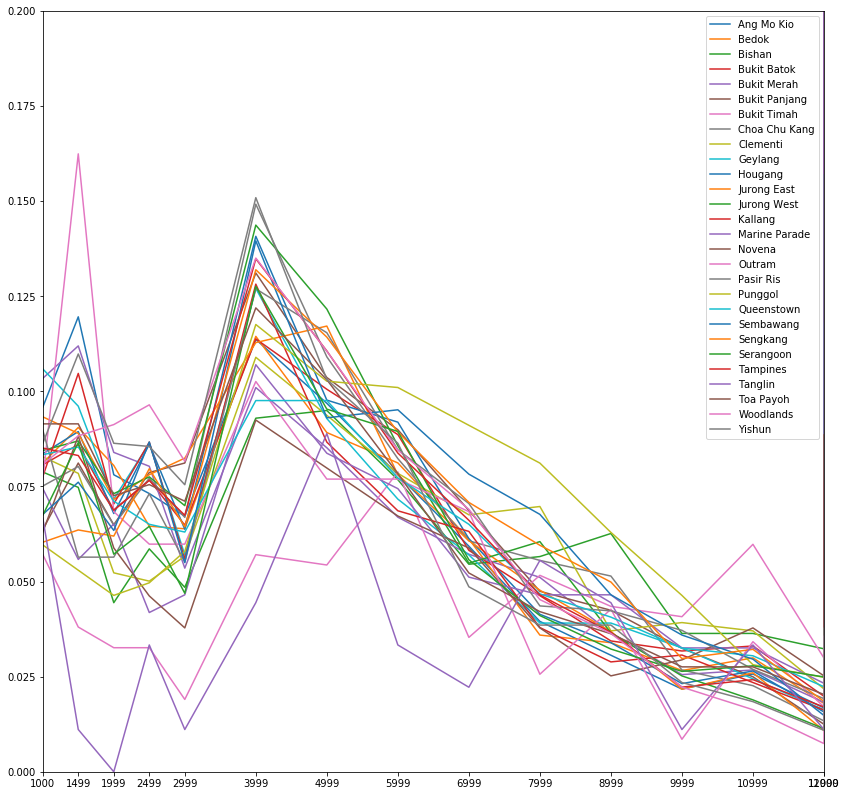

In [13]:
df_[col].transpose().plot(kind='line', figsize=(14,14), ylim=(0.0,0.2), xticks=col)

From the plot, we can see a general trend across all regions. This shows that middle to upper class households in Singapore are rather evenly distributed across the nation. However, for income range below 1999, there is alot of variants in the proportion numbers. There might be some communities with more low income than others. Since our goal is to assess the top priority of in need per planning area, we shall cumulate the population below 1999 salary and combine them to form out low income category.

In [14]:
df_ = df_.iloc[:,0:3].sum(axis=1).to_frame(name='% of low income')

In [15]:
df_.sort_values('% of low income',ascending=False)

,% of low income
Outram,0.307692
Bukit Merah,0.299270
Ang Mo Kio,0.293478
Yishun,0.282481
Geylang,0.273616
Woodlands,0.260386
Toa Payoh,0.255443
Jurong East,0.253796
Kallang,0.252708
Bedok,0.252162


__4. Query Fourspace API for available budget food services in planning area vicinity__

In [16]:
import requests

CLIENT_ID = 'DNO35KRVOOLDRVW2M3SSEALEVFWOW4RZ3Z1M4Y5XOA5S5EDX' # your Foursquare ID
CLIENT_SECRET = '42FZ3ZJ1A2XAUGN0PT124LPL1XKX2FEIWFGNTQWEG0CTLMHX' # your Foursquare Secret
VERSION = '20200603' # Foursquare API version

venues_list=[]

for planning_area in planning_areas:

    lat = df.loc[planning_area,'Latitude']
    lng = df.loc[planning_area,'Longitude']

    radius = 2500
    LIMIT = 500

    cat_id = '4d4b7105d754a06374d81259' # Food
    price_range = 1 
    '''
    1 being the least expensive, 4 being the most expensive. 
    For food venues, in the United States, 1 is < $10 an entree, 2 is $10-$20 an entree, 
    3 is $20-$30 an entree, 4 is > $30 an entree.
    '''

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&price={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat,
        lng,
        cat_id,
        price_range,
        radius,
        LIMIT
    )

    # make the GET request
    results = requests.get(url).json()
    result = results["response"]['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        planning_area, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in result])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Neighborhood', 
          'Neighborhood Latitude', 
          'Neighborhood Longitude', 
          'Venue', 
          'Venue Latitude', 
          'Venue Longitude', 
          'Venue Category']

In [17]:
food_count = nearby_venues.groupby('Neighborhood').size().to_frame(name='# of budget food places')

In [18]:
df_.index.name = 'Neighborhood'
final_df = pd.merge(df_,food_count, how='left', on='Neighborhood')
final_df.head()

,% of low income,# of budget food places
Neighborhood,,
Ang Mo Kio,0.293478,78
Bedok,0.252162,73
Bishan,0.197980,66
Bukit Batok,0.235450,18
Bukit Merah,0.299270,100


__5. Normalise features__

Since the two features have different ranges, by normalising/standardizing the features around the center at 0 and with a standard deviation of 1, we can prevent the bias contributed by different scales. This is because the measurements of each feature is in different units and do not contribute equally to the analysis.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(final_df),columns = final_df.columns)

C:\Users\ongyi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ongyi\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


__6. Perform K-means Clustering__

Optimal K is observed by find the sum of squared distances across a range of K values.

In [20]:
from sklearn.cluster import KMeans

kclusters = range(1,29)
sum_sq_err = []

for k in kclusters:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_scaled)
    centroids = kmeans.cluster_centers_
    sum_sq_err.append(kmeans.inertia_)     #    Sum of squared distances of samples to their closest cluster center.

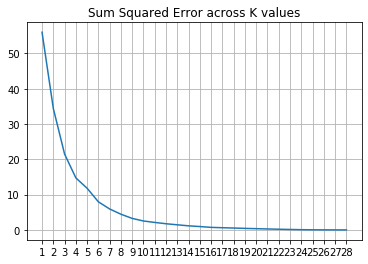

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(kclusters,sum_sq_err)
plt.xticks(kclusters)
plt.grid()
plt.title('Sum Squared Error across K values')

 

plt.show()

In this case, any number of cluster from 2 to 5 is feasible. We'll select 5 to better segment and identify different kinds of in need households (low income, high number vs low number of available food services)

In [22]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_scaled)

In [23]:
final_df.head()

,% of low income,# of budget food places
Neighborhood,,
Ang Mo Kio,0.293478,78
Bedok,0.252162,73
Bishan,0.197980,66
Bukit Batok,0.235450,18
Bukit Merah,0.299270,100


In [24]:
df.index.name = 'Neighborhood'
map_df = pd.concat([df[['Latitude','Longitude']],final_df],axis=1)
map_df['Cluster ID'] = kmeans.labels_
map_df.reset_index(inplace=True)
map_df

,Neighborhood,Latitude,Longitude,% of low income,# of budget food places,Cluster ID
0,Ang Mo Kio,1.370073,103.849516,0.293478,78,4
1,Bedok,1.323976,103.930216,0.252162,73,3
2,Bishan,1.350986,103.848255,0.197980,66,3
3,Bukit Batok,1.349057,103.749591,0.235450,18,1
4,Bukit Merah,1.270439,103.828318,0.299270,100,4
5,Bukit Panjang,1.378629,103.762136,0.209738,61,3
6,Bukit Timah,1.354690,103.776372,0.127717,39,2
7,Choa Chu Kang,1.384749,103.744534,0.220165,23,1
8,Clementi,1.315100,103.765231,0.213508,70,3
9,Geylang,1.318186,103.887056,0.273616,100,4


The below two cells, sort the data according to either percentage of low income or number of budget food services nearby, to identify the pattern of the cluster IDs assigned to each planning area

In [25]:
map_df.sort_values(by=['% of low income','# of budget food places'],ascending=[False,True])

,Neighborhood,Latitude,Longitude,% of low income,# of budget food places,Cluster ID
16,Outram,1.282870,103.837860,0.307692,91,4
4,Bukit Merah,1.270439,103.828318,0.299270,100,4
0,Ang Mo Kio,1.370073,103.849516,0.293478,78,4
27,Yishun,1.429384,103.835028,0.282481,45,1
9,Geylang,1.318186,103.887056,0.273616,100,4
26,Woodlands,1.436897,103.786216,0.260386,46,1
25,Toa Payoh,1.335391,103.849741,0.255443,95,4
11,Jurong East,1.333115,103.742297,0.253796,62,3
13,Kallang,1.310759,103.866262,0.252708,98,4
1,Bedok,1.323976,103.930216,0.252162,73,3


In [26]:
map_df.sort_values(by=['# of budget food places','% of low income'],ascending=[True,False])

,Neighborhood,Latitude,Longitude,% of low income,# of budget food places,Cluster ID
3,Bukit Batok,1.349057,103.749591,0.235450,18,1
7,Choa Chu Kang,1.384749,103.744534,0.220165,23,1
12,Jurong West,1.339636,103.707339,0.244486,33,1
6,Bukit Timah,1.354690,103.776372,0.127717,39,2
20,Sembawang,1.449093,103.820055,0.207188,40,1
27,Yishun,1.429384,103.835028,0.282481,45,1
26,Woodlands,1.436897,103.786216,0.260386,46,1
17,Pasir Ris,1.373031,103.949255,0.202564,56,3
18,Punggol,1.405258,103.902330,0.158940,60,2
5,Bukit Panjang,1.378629,103.762136,0.209738,61,3


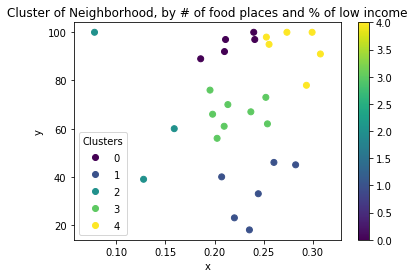

In [27]:
scatter_df = map_df.set_index('Neighborhood')
x = scatter_df['% of low income']
y = scatter_df['# of budget food places']
Cluster = scatter_df['Cluster ID']

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Cluster of Neighborhood, by # of food places and % of low income')
ax.legend(*scatter.legend_elements(),loc="lower left", title="Clusters")
plt.colorbar(scatter)
plt.show()

From the cluster scatter plot, we can see that cluster ID 1 (dark-blue) is our top priority, since the planning area have largest proportion of low income and very low number of food services nearby. The next on the list would be cluster ID 4 (yellow) since they have low income but rather high number of food services nearby.

__7. Get cluster points on map__

In [29]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

latitude = 1.3521
longitude = 103.8198
k = 5

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(map_df['Latitude'], map_df['Longitude'], map_df['Neighborhood'], map_df['Cluster ID']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As seen on the map, our priority clusters are cluster 1 (purple) and 4 (orange).

Not only is this analysis beneficial for providing information of top priority planning areas with in need households, but also beneficial to identify the pattern of different classes within and between communities.